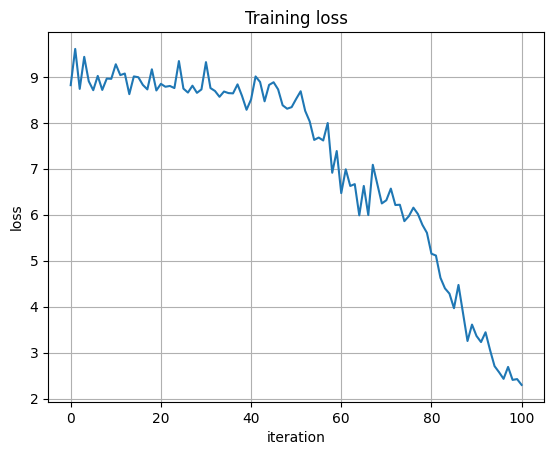

A: [0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 1. 0.]
B: [0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 0.]
Expected: [0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 0.]
Predicted: [0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 0. 0.]
---
A: [0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0.]
B: [0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 1.]
Expected: [0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0.
 1. 0. 1. 0. 1. 1. 1. 1.]
Predicted: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1.]
---
A: [0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 0. 1. 0.]
B: [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0

In [2]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

def create_subtraction_dataset(nb_samples, sequence_len):
    max_int = 2**(sequence_len - 1)
    format_str = '{:0' + str(sequence_len) + 'b}'
    nb_inputs = 2
    nb_outputs = 1
    X = np.zeros((nb_samples, sequence_len, nb_inputs))
    T = np.zeros((nb_samples, sequence_len, nb_outputs))
    for i in range(nb_samples):
        a = np.random.randint(0, max_int)
        b = np.random.randint(0, max_int)
        if a < b:
            a, b = b, a
        X[i,:,0] = list(reversed([int(bit) for bit in format_str.format(a)]))
        X[i,:,1] = list(reversed([int(bit) for bit in format_str.format(b)]))
        T[i,:,0] = list(reversed([int(bit) for bit in format_str.format(a - b)]))
    return X, T

class TensorLinear:
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = np.random.uniform(-a, a, (n_in, n_out)) if W is None else W
        self.b = np.zeros((n_out)) if b is None else b
        self.bpAxes = tuple(range(tensor_order - 1))

    def forward(self, X):
        return np.tensordot(X, self.W, axes=((-1), (0))) + self.b

    def backward(self, X, gY):
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        gX = np.tensordot(gY, self.W.T, axes=((-1), (0)))
        return gX, gW, gB

class LogisticClassifier:
    def forward(self, X):
        return 1. / (1. + np.exp(-X))

    def backward(self, Y, T):
        return (Y - T) / (Y.shape[0] * Y.shape[1])

    def loss(self, Y, T):
        return -np.mean((T * np.log(Y + 1e-8)) + ((1-T) * np.log(1-Y + 1e-8)))

class TanH:
    def forward(self, X):
        return np.tanh(X)

    def backward(self, Y, output_grad):
        return (1.0 - (Y**2)) * output_grad

class RecurrentStateUpdate:
    def __init__(self, nbStates, W, b):
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        return self.tanh.forward(Xk + self.linear.forward(Sk))

    def backward(self, Sk0, Sk1, output_grad):
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

class RecurrentStateUnfold:
    def __init__(self, nbStates, nbTimesteps):
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))
        self.S0 = np.zeros(nbStates)
        self.nbTimesteps = nbTimesteps
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)

    def forward(self, X):
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:, 0, :] = self.S0
        for k in range(self.nbTimesteps):
            S[:, k+1, :] = self.stateUpdate.forward(X[:, k, :], S[:, k, :])
        return S

    def backward(self, X, S, gY):
        gSk = np.zeros_like(gY[:, self.nbTimesteps-1, :])
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)
        gBSum = np.zeros_like(self.b)
        for k in range(self.nbTimesteps-1, -1, -1):
            gSk += gY[:, k, :]
            gZ[:, k, :], gSk, gW, gB = self.stateUpdate.backward(
                S[:, k, :], S[:, k+1, :], gSk)
            gWSum += gW
            gBSum += gB
        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

class RnnBinarySubtractor:
    def __init__(self, nb_inputs, nb_outputs, nb_states, sequence_len):
        self.tensorInput = TensorLinear(nb_inputs, nb_states, 3)
        self.rnnUnfold = RecurrentStateUnfold(nb_states, sequence_len)
        self.tensorOutput = TensorLinear(nb_states, nb_outputs, 3)
        self.classifier = LogisticClassifier()
        self.sequence_len = sequence_len

    def forward(self, X):
        recIn = self.tensorInput.forward(X)
        S = self.rnnUnfold.forward(recIn)
        Z = self.tensorOutput.forward(S[:, 1:self.sequence_len+1, :])
        Y = self.classifier.forward(Z)
        return recIn, S, Z, Y
    def loss(self, Y, T):
        return self.classifier.loss(Y, T)

    def backward(self, X, Y, recIn, S, T):
        gZ = self.classifier.backward(Y, T)
        gRecOut, gWout, gBout = self.tensorOutput.backward(S[:, 1:self.sequence_len+1, :], gZ)
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0

    def getBinaryOutput(self, X):
        _, _, _, Y = self.forward(X)
        return np.around(Y)

    def getParamGrads(self, X, T):
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(X, Y, recIn, S, T)
        return [g for g in itertools.chain(
            np.nditer(gS0), np.nditer(gWin), np.nditer(gBin),
            np.nditer(gWrec), np.nditer(gBrec), np.nditer(gWout), np.nditer(gBout))]

    def get_params_iter(self):
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

sequence_len = 32
nb_train = 2000
X_train, T_train = create_subtraction_dataset(nb_train, sequence_len)
RNN = RnnBinarySubtractor(2, 1, 16, sequence_len)

lmbd = 0.5
learning_rate = 0.05
momentum_term = 0.80
eps = 1e-6
mb_size = 100

nbParameters = sum(1 for _ in RNN.get_params_iter())
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]
ls_of_loss = [RNN.loss(RNN.getBinaryOutput(X_train[:100]), T_train[:100])]

for i in range(5):
    for mb in range(nb_train // mb_size):
        X_mb = X_train[mb:mb+mb_size]
        T_mb = T_train[mb:mb+mb_size]
        V_tmp = [v * momentum_term for v in Vs]
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)
        for pIdx, P in enumerate(RNN.get_params_iter()):
            maSquare[pIdx] = lmbd * maSquare[pIdx] + (1 - lmbd) * backprop_grads[pIdx]**2
            pGradNorm = (learning_rate * backprop_grads[pIdx]) / (np.sqrt(maSquare[pIdx]) + eps)
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm
            P -= pGradNorm
        ls_of_loss.append(RNN.loss(RNN.getBinaryOutput(X_mb), T_mb))

plt.plot(ls_of_loss)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.title("Training loss")
plt.grid(True)
plt.show()

Xtest, Ttest = create_subtraction_dataset(5, sequence_len)
Y = RNN.getBinaryOutput(Xtest)
for i in range(5):
    print("A:", Xtest[i,:,0][::-1])
    print("B:", Xtest[i,:,1][::-1])
    print("Expected:", Ttest[i,:,0][::-1])
    print("Predicted:", Y[i,:,0][::-1])
    print("---")
